### Imports 

In [1]:
import h5py
from tqdm.keras import TqdmCallback
import datetime
import scipy.ndimage as nd
from vqvae import *
import scipy

2025-03-18 05:28:01.954107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742275681.991236     739 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742275681.998196     739 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742275682.017820     739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742275682.017845     739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742275682.017848     739 computation_placer.cc:177] computation placer alr

### Load Data

In [2]:
with h5py.File('data/q_dataset.h5', 'r') as file:
    full_data = np.array(file['Data'])
    x_train, x_test = train_test_split(full_data, test_size=0.25, shuffle=True)
data_variance = np.var(x_train)

In [3]:
signal_labels = ["g", "t", "w", "z"]

signals_file = ["data/g_dataset.h5", "data/t_dataset.h5","data/w_dataset.h5","data/z_dataset.h5"]
signal_data = []
for i, label in enumerate(signal_labels):
    print(label)
    with h5py.File(signals_file[i], 'r') as file:

        test_data = np.array(file['Data'])
    signal_data.append(test_data)

g
t
w
z


### Train Model

In [4]:
latent_dim = 16
num_embeddings = 1024
commitment_cost = 0.25
decay = 0.99
attempt = 0
output_file = f'results/VQVAE_{latent_dim}_{num_embeddings}_{attempt}'

In [ ]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim, num_embeddings, commitment_cost, decay)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train, 
                  epochs=100, batch_size=64, validation_split = 0.05, verbose=0,
                  callbacks=[
                      keras.callbacks.EarlyStopping(monitor='val_reconstruction_loss', mode='min', patience=10, restore_best_weights=True, min_delta = 0.00),
                      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
                      TqdmCallback()])

In [ ]:
vqvae_trainer.vqvae.save(f'model_{latent_dim}_{num_embeddings}_{attempt}.keras')

### Load Model

In [6]:
latent_dim = 16
num_embeddings = 1024
attempt = 0

vqvae = vqvae_trainer.vqvae#tf.keras.models.load_model(f'model_{latent_dim}_{num_embeddings}_{attempt}.keras', 
        #                           custom_objects={"vector_quantizer": VectorQuantizer, "mse_loss": mse_loss},)

### Evaluate

In [7]:
bkg_prediction = vqvae.predict(x_test, verbose = 0)
  
signal_results = []
for i, label in enumerate(signal_labels):
    signal_prediction = vqvae.predict(signal_data[i], verbose = 0)
    signal_results.append([label, signal_data[i], signal_prediction])

W0000 00:00:1731466009.816138     477 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
2024-11-13 02:46:49.854658: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 24 configs for triton_gemm_dot.97 on a single thread.
W0000 00:00:1731466013.475020     477 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
2024-11-13 02:46:53.499623: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 24 configs for triton_gemm_dot.129 on a single thread.
W0000 00:00:1731466024.773283     477 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
2024-11-13 02:47:04.795573: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 22 configs for triton_gemm_dot.129 on a single thread.
W0000 00:00:1731466046.625978     477 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
2024-11-13 02:47:26.648123: W external/local_xla

In [8]:
total_loss = []
total_loss.append(mse_loss(x_test.astype('float32'), bkg_prediction.astype('float32')).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2]).numpy())

In [ ]:
signal_labels = ["background", "g", "t", "w", "z"]
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=100, label=label, density = True, histtype='step', fill=False, linewidth=1.5, )#range=[0, 3e4])
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()


target_background = np.zeros(total_loss[0].shape[0])
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.title(f"ROC ")#VQ-VAE, latent_dim = {latent_dim}, embeddings = {num_embeddings}")
# a -> b
# b -| a

fpr_loss = roc_curve(true_Val, predVal_loss)
auc_loss = auc(tpr_loss, fpr_loss)
plt.plot(fpr_loss, tpr_loss,, "-", linewidth = 1.5, label = label)#plt.plot(tpr_poss, fpr

import numpy as np
plt.show()

### Codebook Visualization

In [10]:
encoder = vqvae.get_layer("encoder")
quantizer = vqvae.get_layer("vector_quantizer")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


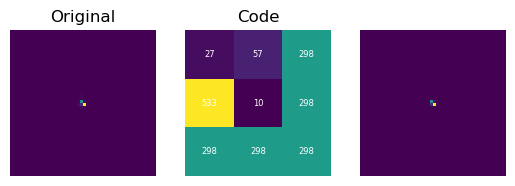

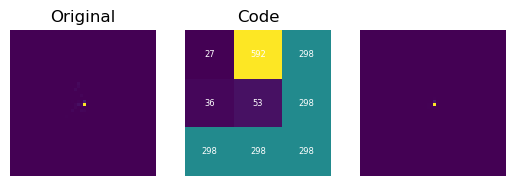

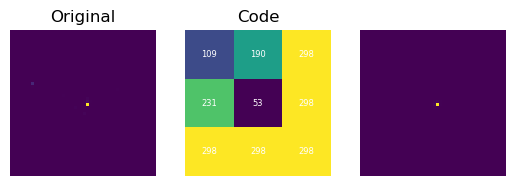

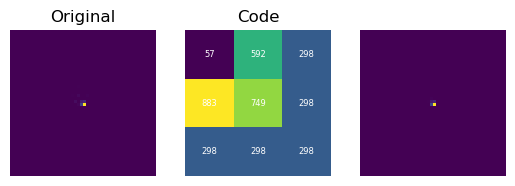

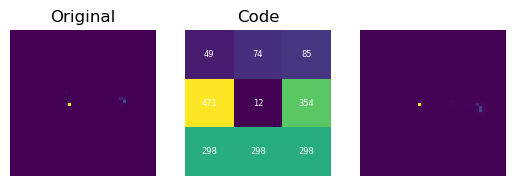

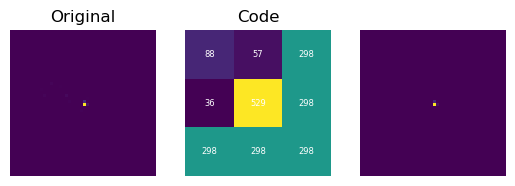

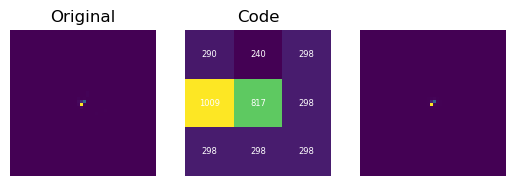

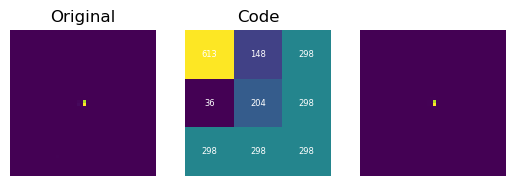

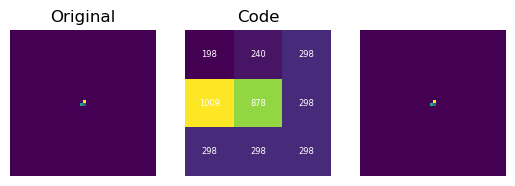

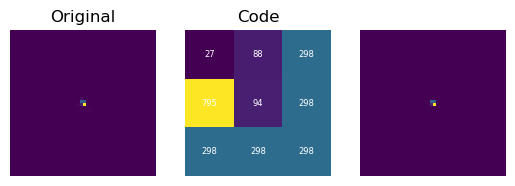

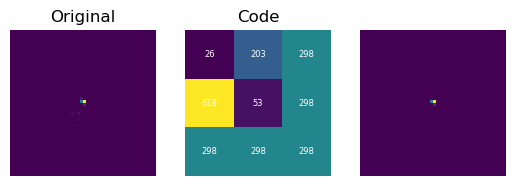

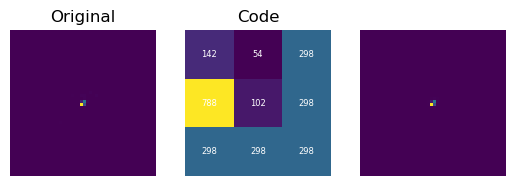

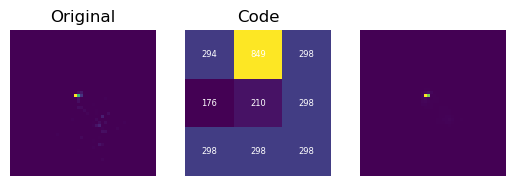

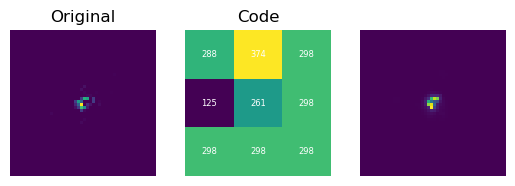

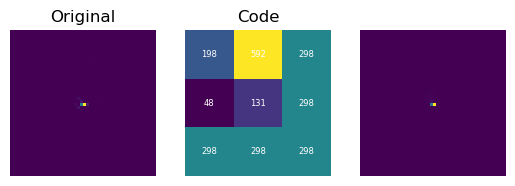

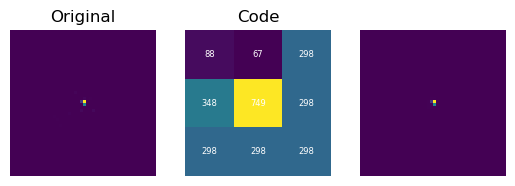

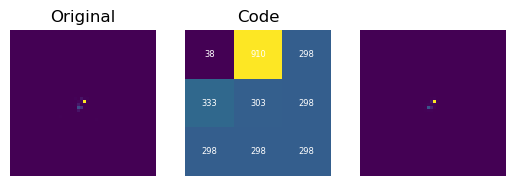

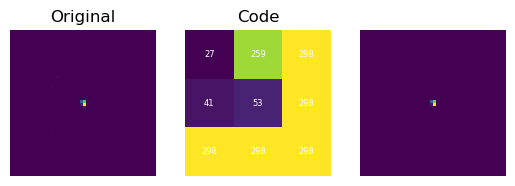

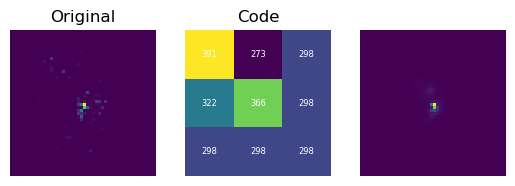

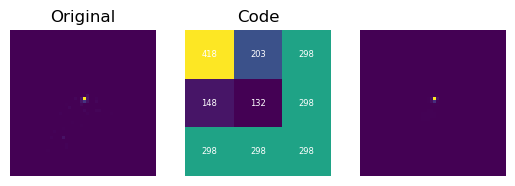

In [11]:
test = x_test[40:60]
encoded_outputs = encoder.predict(test)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
# print(codebook_indices[0].shape)
# print(quantized[0].shape)



for i in range(len(test)):
    plt.subplot(1, 3, 1)
    plt.imshow(test[i])
    plt.title("Original")
    plt.axis("off")


               
    plt.subplot(1, 3, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    #plt.colorbar()
    for a in range(codebook_indices[i].shape[0]):
        for b in range(codebook_indices[i].shape[1]):
            plt.text(b, a, str(codebook_indices[i][a, b]), ha='center', va='center', color='white', fontsize=6)

    plt.subplot(1,3,3)
    plt.imshow(bkg_prediction[40+i])
    plt.axis("off")
    plt.show()


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step


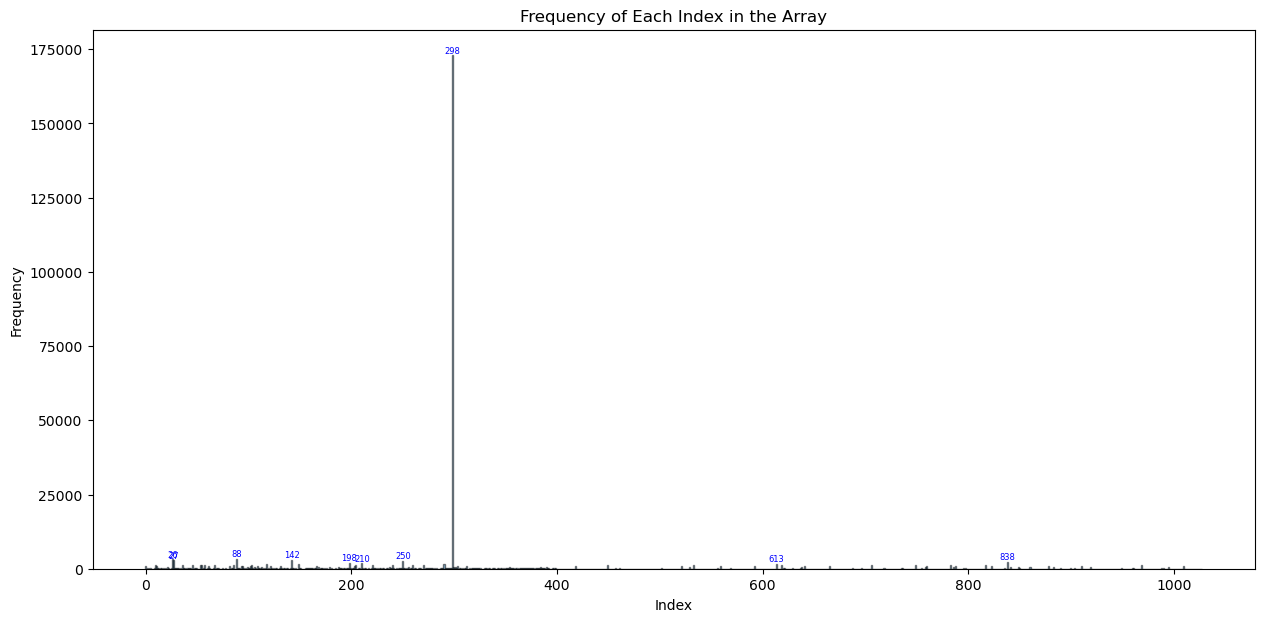

In [12]:
encoded_outputs = encoder.predict(x_test)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
indices = codebook_indices.numpy()
unique, counts = np.unique(indices, return_counts=True)


full_counts = np.zeros(1028, dtype=int)
full_counts[unique] = counts
#full_counts = np.minimum(full_counts,10000)
top_indices = np.argsort(full_counts)[-10:]


plt.figure(figsize=(15, 7))
plt.bar(range(1028),full_counts, width=1.0, edgecolor='black', alpha=0.5, )
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Frequency of Each Index in the Array')


for idx in top_indices:
    plt.text(idx, full_counts[idx], str(idx), ha='center', va='bottom', color='blue', alpha=1, fontsize=6)

plt.show()

4534/4534 ━━━━━━━━━━━━━━━━━━━━ 3s 703us/step


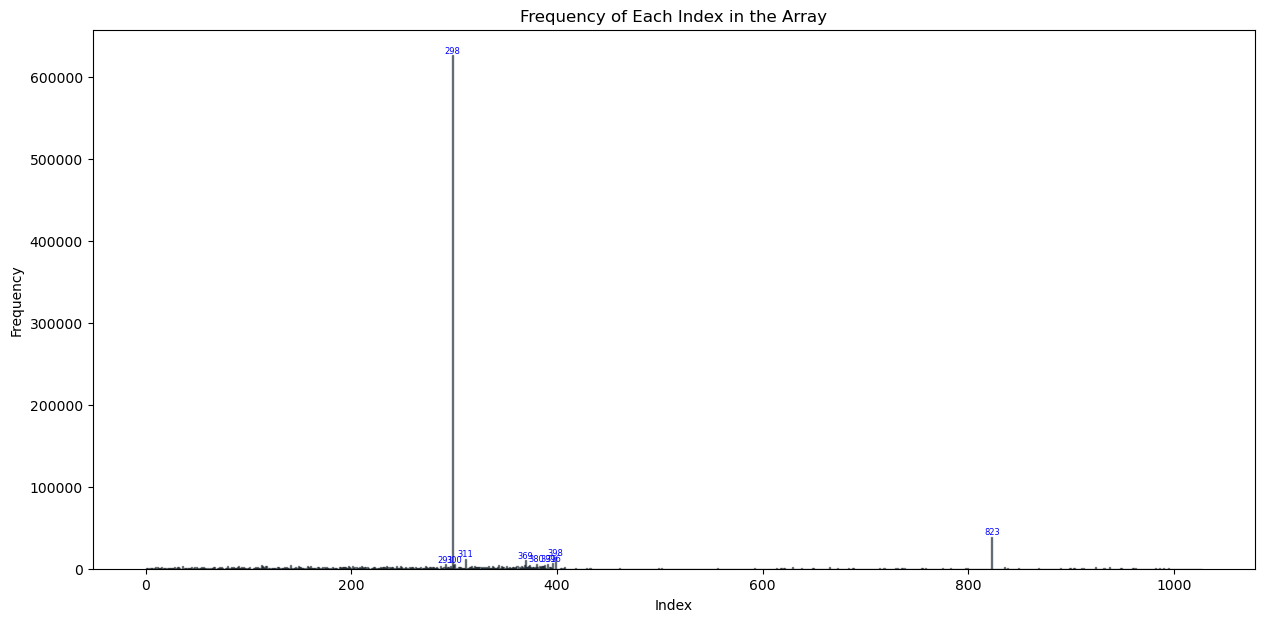

In [13]:
encoded_outputs = encoder.predict(np.array(signal_results[1][1]))
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
indices = codebook_indices.numpy()
#print(indices)

unique, counts = np.unique(indices, return_counts=True)


full_counts = np.zeros(1028, dtype=int)
full_counts[unique] = counts
#full_counts = np.minimum(full_counts,2000)
top_indices = np.argsort(full_counts)[-10:]


plt.figure(figsize=(15, 7))
plt.bar(range(1028),full_counts, width=1.0, edgecolor='black', alpha=0.5, )
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Frequency of Each Index in the Array')


for idx in top_indices:
    plt.text(idx, full_counts[idx], str(idx), ha='center', va='bottom', color='blue', alpha=1, fontsize=6)

plt.show()

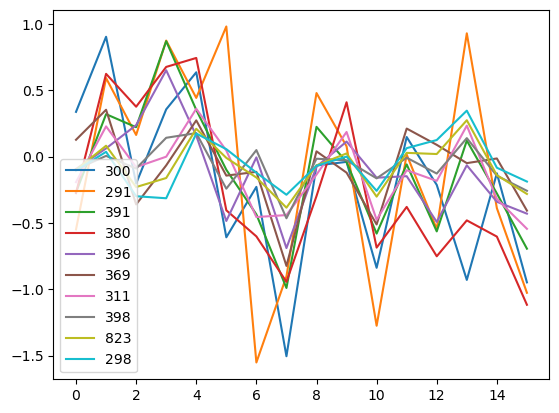

In [14]:

for embedding in top_indices:
    plt.plot(quantizer.embeddings[:,embedding], label=embedding, )
plt.legend()
plt.show()

### Other Stuff

#### Looking at the Encoder Outputs and Quantized Layer

In [15]:
loss_quantized = []
encoded_outputs = encoder.predict(x_test)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
loss_quantized.append(mse_loss(encoded_outputs, quantized))

for i, signal_X in enumerate(signal_data):
    encoded_outputs = encoder.predict(signal_X)
    flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
    quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
    loss_quantized.append(mse_loss(encoded_outputs, quantized))


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 3s 681us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 3s 684us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 3s 703us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 3s 705us/step


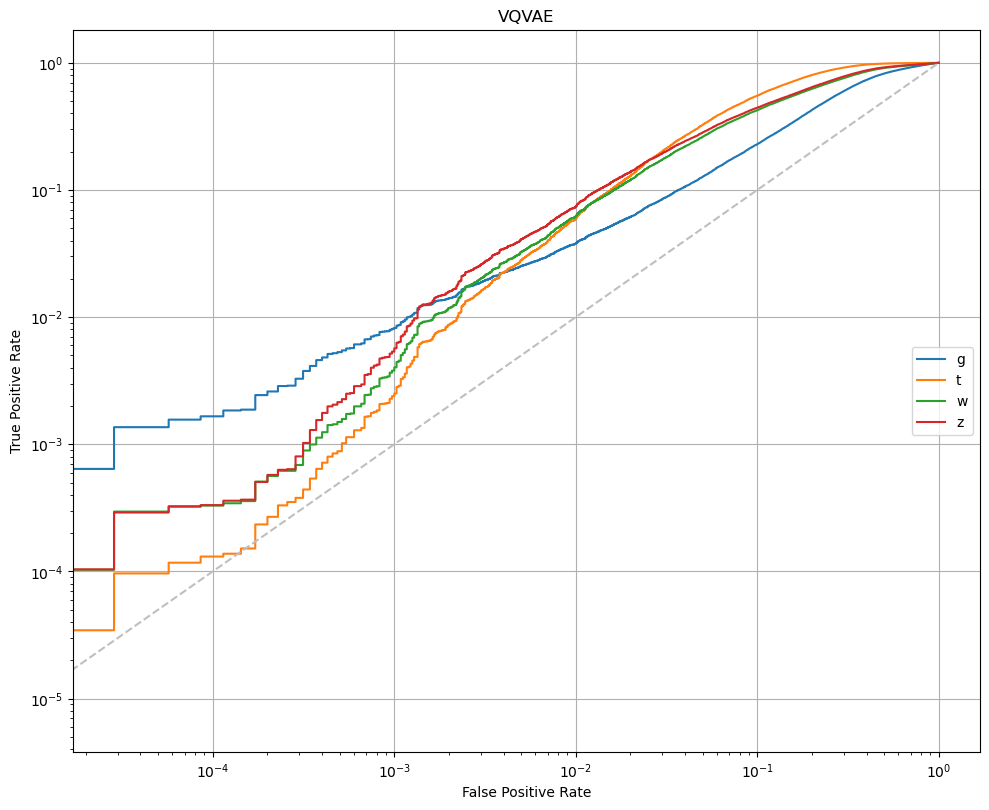

In [16]:
target_background = np.zeros(loss_quantized[0].shape[0])
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(loss_quantized[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((loss_quantized[i], loss_quantized[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

plt.title("VQVAE")
plt.show()

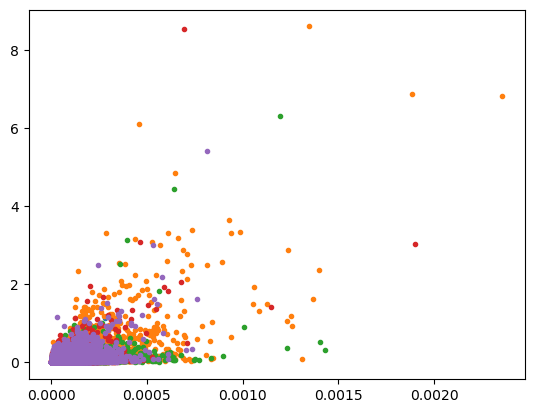

In [17]:
for i in range(len(total_loss)):
    plt.plot(total_loss[i], loss_quantized[i], '.')

#### Looking at the Quantized Outputs

In [18]:
def get_model(latent_dim=16):
    latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
    x = layers.BatchNormalization()(latent_inputs)
    x = layers.Conv3D(filters=1, kernel_size=(1, 1, 16), padding='valid', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(5, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(latent_inputs, x, name="decoder")

In [19]:
encoded_outputs = encoder.predict(x_train)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))

mse_losses = mse_loss(x_train, vqvae.predict(x_train))


3278/3278 ━━━━━━━━━━━━━━━━━━━━ 2s 754us/step
3271/3278 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step

W0000 00:00:1731466976.465575     477 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
2024-11-13 03:02:56.487357: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 24 configs for triton_gemm_dot.129 on a single thread.


3278/3278 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [20]:
target_background = np.zeros(mse_losses[0].shape[0])
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(loss_quantized[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((loss_quantized[i], loss_quantized[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

plt.title("VQVAE")
plt.show()

IndexError: tuple index out of range